In [57]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import scipy.integrate as integrate
import pandas as pd

In [58]:
m=2.
sim = rebound.Simulation()
sim.add(m=3.)
sim.add(m=1.e-5, e=0.001, P=2.)
sim.add(m=1.e-5, e=0.001, P=(m+1)/m*2.)
sim.move_to_com()
ps = sim.particles

In [59]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.Gamma = property(Gamma)

In [60]:
def HKep(p):
    return -p.mjac**3*(sim.G*p.Mjac)**2/(2.*p.Lambda**2)
def HintAvg(sim):
    p1 = sim.particles[1]
    p2 = sim.particles[2]
    G = sim.G
    Hint = 0
    #Hint += f1(0, sim)
    Hint += f27(m+1, sim)*np.sqrt(2*p1.Gamma/p1.Lambda)*np.cos((m+1)*p2.l-m*p1.l-p1.pomega)
    Hint += f31(m+1, sim)*np.sqrt(2*p2.Gamma/p2.Lambda)*np.cos((m+1)*p2.l-m*p1.l-p2.pomega)
    return Hint*p1.mjac/p1.Mjac*2*HKep(p2)
def H(sim):
    return HKep(sim.particles[1]) + HKep(sim.particles[2])# + HintAvg(sim)
def f1(j, sim):
    alpha = sim.particles[1].a/sim.particles[2].a
    return integrate.quad(lambda x: np.cos(j*x)/np.sqrt(1.-2*alpha*np.cos(x)+alpha**2), 0, 2*np.pi)[0]/np.pi
def f27(j, sim):
    return -0.46-0.802*(j-1)
def f31(j, sim):
    return 0.87+0.802*(j-1)

In [61]:
Norbits = 5000
Nout = 10000
tmax = Norbits*sim.particles[2].P
times = np.linspace(0, tmax, Nout, endpoint=False)
Hs, Hunscaled = np.zeros(Nout), np.zeros(Nout)
Hints = np.zeros(Nout)
a1, a2 = np.zeros(Nout), np.zeros(Nout)
e1, e2 = np.zeros(Nout), np.zeros(Nout)
po1, po2 = np.zeros(Nout), np.zeros(Nout)
H0 = H(sim)
p1 = sim.particles[1]
p2 = sim.particles[2]
a10 = p1.a
a20 = p2.a
e10 = p1.e
e20 = p2.e
for i, time in enumerate(times):
    sim.integrate(time)
    Hs[i] = np.abs((H(sim) - H0)/H0)
    Hints[i] = HintAvg(sim)
    Hunscaled[i] = H(sim)
    a1[i] = np.abs((p1.a - a10)/a10)
    a2[i] = np.abs((p2.a - a20)/a20)
    e1[i] = p1.e#np.abs((p1.e - e10)/e10)
    e2[i] = p2.e#np.abs((p2.e - e20)/e20)
    po1[i] = p1.pomega
    po2[i] = p2.pomega

In [62]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

nyq = 0.3333333333333334


/Users/dtamayo/miniconda2/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


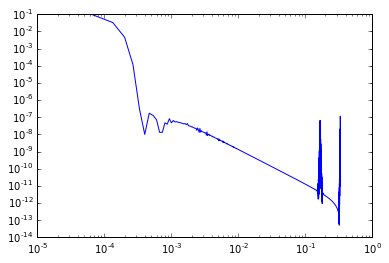

In [63]:
from scipy.fftpack import fft

T = tmax/Nout # sample spacing
nyq= 1./(2.*T) # Nyquist freq
print("nyq = {0}".format(nyq))
from scipy.signal import kaiser
w = kaiser(Nout, 14)
yf = fft(Hunscaled*w)
xf = np.linspace(0., nyq, Nout/2)
fig, ax = plt.subplots()
ax.plot(xf[1:], np.abs(yf[1:Nout/2]))
ax.set_yscale('log')
ax.set_xscale('log')

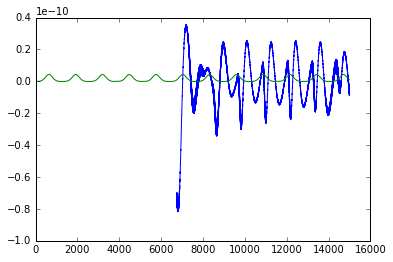

In [64]:
fs = Nout/tmax
lowcut = 0.001#1/sim.particles[1].P/4
highcut = 0.1
#print("Cutting frequencies higher than {0}".format(cutoff))
Havg = butter_bandpass_filter(Hunscaled, lowcut, highcut, fs)
fig, ax = plt.subplots()
#ax.plot(times, Hunscaled+4.071e-3)
ax.plot(times[4500:], Havg[4500:])
ax.plot(times, Hints)
#ax.set_yscale('log')

In [65]:
1/sim.particles[1].P

0.5001406522221177

In [66]:
f1(0, sim)*p1.mjac/p1.Mjac*2*HKep(p2)

-2.7891475778203061e-10

In [67]:
HKep(p2)

-1.7021197918978612e-05